In [1]:
from itertools import islice, combinations, product
from collections import defaultdict
from goatools import obo_parser
from functools import partial

import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw-data"
YEAST_DIRECTORY = f"{DATA_DIRECTORY}/processed-data/organisms/yeast"
NETWORK_DIRECTORY = f"{YEAST_DIRECTORY}/networks"
MATRIX_DIRECTORY  = f"{YEAST_DIRECTORY}/distance-matrices"
ANNOTATION_DIRECTORY  = f"{YEAST_DIRECTORY}/annotations"

# Preprocessing

In [3]:
namespace = 'CC'
correction = 'BH'

alpha = 0.05
lb_GO = 5
ub_GO = 500
min_lvl = 0
max_lvl = 100

In [4]:
PPI = nx.read_edgelist(f"{NETWORK_DIRECTORY}/PPI_BioGRID.txt")

annotation_df = pd.read_csv(f"{ANNOTATION_DIRECTORY}/GO_{namespace}_BioGRID-SGD.csv")

go_dag = obo_parser.GODag(f"{RAW_DATA_DIRECTORY}/go-basic.obo")

gene_population = set(PPI.nodes())
GO_population = {go_id for go_id in set(annotation_df.GO_ID) 
                           if (lb_GO <= len(annotation_df[annotation_df.GO_ID == go_id]) <= ub_GO and
                               min_lvl <= go_dag[go_id].level <= max_lvl)}

annotation_df = annotation_df[annotation_df.GO_ID.isin(GO_population)]

/home/clusterduck123/Desktop/git/supplements/data/raw-data/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


In [5]:
# Conversion dictionaries
GO2genes = pd.Series({go_id: set(genes.Systematic_ID) for go_id, genes in annotation_df.groupby('GO_ID')}, 
                     name='nb_genes')
gene2GO = defaultdict(set)
gene2GO  = {gene : set(go_ids.GO_ID)        for gene, go_ids in annotation_df.groupby('Systematic_ID')}
global_GO_counter = GO2genes.apply(len)

In [6]:
def get_number_of_pre_runs(CLUSTER_DIRECTORY, n_clusters = 99):
    splitted_file_names = [name.split('_') for name in os.listdir(CLUSTER_DIRECTORY)]
    pre_runs = [int(run) for run, ncluster, db_txt in splitted_file_names if ncluster == str(n_clusters)]
    if pre_runs:
        return max(pre_runs)
    else:
        return -1

# Load

In [7]:
def get_enrichments(alpha, p_values, cluster_list, correction):
    relevant_p_values = [p_values[str(cluster_idx)][cluster2GO(cluster)] 
                             for cluster_idx,cluster in enumerate(cluster_list)] 
    
    sorted_p_values = sorted(p for p_cluster in relevant_p_values
                               for p in p_cluster)
    m = len(sorted_p_values)
    if   correction == 'BY':
        c = np.log(m) + np.euler_gamma + 1/(2*m)
    elif correction == 'BH':
        c = 1
    else:
        print("Correction not known!")
        raise Exception
    for k,P_k in enumerate(sorted_p_values,1):
        if P_k > k/(m*c) * alpha:
            break
    threshold = sorted_p_values[k-2]
    return p_values < threshold


def cluster2GO(cluster):
    return set.union(*(gene2GO.get(gene, set()) for gene in cluster))

def is_annotated_in(gene, GO_set):
    return not gene2GO.get(gene,set()).isdisjoint(GO_set)

In [8]:
cluster_coverages = {}
GO_coverages      = {}
gene_coverages    = {}

In [21]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100
MAX_RUNS     = 30

cluster_coverages['GDV'] = defaultdict(pd.DataFrame)
GO_coverages['GDV']      = defaultdict(pd.DataFrame)
gene_coverages['GDV']    = defaultdict(pd.DataFrame)

### GDV

In [24]:
method = 'kmedoid'

for distance in ['canberra',
    
                'cityblock',
                'euclidean',
                'chebyshev',
                
                'normalized1-l1',
                'normalized1-l2',
                'normalized1-linf',]:
    CLUSTER_DIRECTORY = f"{YEAST_DIRECTORY}/clusterings/GDV/{distance}/{method}"
    PVALUE_DIRECTORY = f"{YEAST_DIRECTORY}/enrichments/GDV/{distance}/{method}/{namespace}"
    runs = min(get_number_of_pre_runs(CLUSTER_DIRECTORY, MAX_CLUSTERS), MAX_RUNS)

    for run in range(runs):
        t1 = time.time()
        print(f"{distance} {run}")
        
        cluster_coverages['GDV'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2)) 
        GO_coverages[     'GDV'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2))
        gene_coverages[   'GDV'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2))
        
        for nb_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS):
            with open(f"{CLUSTER_DIRECTORY}/{run}_{nb_clusters}_BioGRID.txt", 'r') as f:
                 cluster_list = [set(line.split()) for line in f]
            cluster_df = pd.Series({gene:cluster_idx 
                                        for cluster_idx,cluster in enumerate(cluster_list) 
                                        for gene in cluster})
            
            p_values = pd.read_csv(f"{PVALUE_DIRECTORY}/{run}_{nb_clusters}_BioGRID.txt", index_col=0)

            enrichments = get_enrichments(alpha, p_values, cluster_list, correction)
            enrichmet_list = [set(enrichments[i][enrichments[i]].index) for i in enrichments.columns]
            
            cluster_coverages['GDV'][distance][run][nb_clusters] = sum(enrichments.any())      / nb_clusters
            GO_coverages[     'GDV'][distance][run][nb_clusters] = sum(enrichments.any(axis=1))/len(GO_population)
            gene_coverages[   'GDV'][distance][run][nb_clusters] = sum(is_annotated_in(gene,enrichmet_list[cluster_idx])
                                                             for gene, cluster_idx in cluster_df.items()) / len(PPI)
            t2 = time.time()
            print(f'{nb_clusters}: {t2-t1:.2f}sec', end='\r')
    print()

canberra 0
canberra 1ec
canberra 2ec
canberra 3ec
canberra 4ec
canberra 5ec
canberra 6ec
canberra 7ec
canberra 8ec
canberra 9ec
canberra 10c
canberra 11c
canberra 12c
canberra 13c
canberra 14c
canberra 15c
canberra 16c
canberra 17c
canberra 18c
canberra 19c
canberra 20c
canberra 21c
canberra 22c
canberra 23c
canberra 24c
canberra 25c
canberra 26c
canberra 27c
canberra 28c
canberra 29c
99: 9.81sec
cityblock 0
cityblock 1c
cityblock 2c
cityblock 3c
cityblock 4c
cityblock 5c
cityblock 6c
cityblock 7c
cityblock 8c
cityblock 9c
cityblock 10
cityblock 11
cityblock 12
cityblock 13
cityblock 14
cityblock 15
cityblock 16
cityblock 17
cityblock 18
cityblock 19
cityblock 20
cityblock 21
cityblock 22
cityblock 23
cityblock 24
cityblock 25
cityblock 26
cityblock 27
cityblock 28
cityblock 29
99: 10.04sec
euclidean 0
euclidean 1c
euclidean 2c
euclidean 3c
euclidean 4c
euclidean 5c
euclidean 6c
euclidean 7c
euclidean 8c
euclidean 9c
euclidean 10
euclidean 11
euclidean 12
euclidean 13
euclidean 14
eucl

In [89]:
cluster_coverages['GCV-A'] = defaultdict(pd.DataFrame)
GO_coverages['GCV-A']      = defaultdict(pd.DataFrame)
gene_coverages['GCV-A']    = defaultdict(pd.DataFrame)

In [104]:
method = 'kmedoid'

for distance in ['all1_normalized1-l1', 'all2_normalized1-l1']:
    
    CLUSTER_DIRECTORY = f"{YEAST_DIRECTORY}/clusterings/GCV-A/{distance}/{method}"
    PVALUE_DIRECTORY = f"{YEAST_DIRECTORY}/enrichments/GCV-A/{distance}/{method}/{namespace}"
    runs = min(get_number_of_pre_runs(CLUSTER_DIRECTORY, MAX_CLUSTERS), MAX_RUNS)

    for run in range(1):
        t1 = time.time()
        print(f"{distance} {run}")
        
        cluster_coverages['GCV-A'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2)) 
        GO_coverages[     'GCV-A'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2))
        gene_coverages[   'GCV-A'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2))
        
        for nb_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS):
            with open(f"{CLUSTER_DIRECTORY}/{run}_{nb_clusters}_BioGRID.txt", 'r') as f:
                 cluster_list = [set(line.split()) for line in f]
            cluster_df = pd.Series({gene:cluster_idx 
                                        for cluster_idx,cluster in enumerate(cluster_list) 
                                        for gene in cluster})
            
            p_values = pd.read_csv(f"{PVALUE_DIRECTORY}/{run}_{nb_clusters}_BioGRID.txt", index_col=0)

            enrichments = get_enrichments(alpha, p_values, cluster_list, correction)
            enrichmet_list = [set(enrichments[i][enrichments[i]].index) for i in enrichments.columns]
            
            cluster_coverages['GCV-A'][distance][run][nb_clusters] = sum(enrichments.any())      / nb_clusters
            GO_coverages[     'GCV-A'][distance][run][nb_clusters] = sum(enrichments.any(axis=1))/len(GO_population)
            gene_coverages[   'GCV-A'][distance][run][nb_clusters] = sum(is_annotated_in(gene,enrichmet_list[cluster_idx])
                                                             for gene, cluster_idx in cluster_df.items()) / len(PPI)
            t2 = time.time()
            print(f'{nb_clusters}: {t2-t1:.2f}sec', end='\r')
    print()

all1_normalized1-l1 0
99: 10.93sec
all2_normalized1-l1 0
99: 11.77sec


# Plots

In [115]:
name2string = {'GCV_tvd':'TVD', 'GCV_hellinger':'GCV_{hell}', 'GDV_GDV-similarity':'Tijana',
               
               'GDV_euclidean'  :'GDV_{L_2}'  , 'GCV_euclidean'  :'GCV_{eucl}'  , 
               'GDV_cityblock'  :'GDV_{L_1}'  , 'GCV_cityblock'  :'GCV_{city}'  , 
               'GDV_seuclidean' :'GDV_{seucl}' , 'GCV_seuclidean' :'GCV_{seucl}' ,
               'GDV_cosine'     :'GDV_{cos}'   , 'GCV_cosine'     :'GCV_{cos}'   ,
               'GDV_correlation':'GDV_{cor}'   , 'GCV_correlation':'GCV_{cor}'   ,
               'GDV_sqeuclidean':'GDV_{eucl^2}', 'GCV_sqeuclidean':'GCV_{eucl^2}',
               'GDV_chebyshev'  :'GDV_{L_{\infty}}' , 'GCV_chebyshev'  :'GCV_{cheby}' ,
               'GDV_canberra'   :'GDV_{can}'   , 'GCV_canberra'   :'GCV_{can}'   ,
               'GDV_braycurtis' :'GDV_{bray}'  , 'GCV_braycurtis' :'GCV_{bray}'  ,
               'GDV_mahalanobis':'GDV_{mahala}', 'GCV_mahalanobis':'GCV_{mahala}',
               
               'GDV_normalized1-l1': 'GDV_{nL_1}',
               'GDV_normalized1-l2': 'GDV_{nL_2}',
               'GDV_normalized1-linf': 'GDV_{nL_{\infty}}',
              
               'GCV-A_all1_normalized1-l1': 'GCV-A_{nL_1}',
               'GCV-A_all2_normalized1-l1': 'GCV-A_{nL_1}'}

In [116]:
plot_methods = [
                'GDV_mahalanobis',
                'GDV_GDV-similarity',
    
                'GDV_cityblock',
                'GDV_euclidean',
                'GDV_chebyshev',
                
                'GDV_normalized1-l1',
                'GDV_normalized1-l2',
                'GDV_normalized1-linf',
    
                'GCV-A_all1_normalized1-l1',
                'GCV-A_all2_normalized1-l1'
    
                #'GDV_canberra'
               ]

In [117]:
blues = sns.color_palette("Blues", 3)
reds  = sns.color_palette("Reds" , 2)

colors = {
           'GDV_mahalanobis'   : reds[0],
           'GDV_GDV-similarity': reds[1],
    
           'GDV_cityblock' : blues[0],
           'GDV_euclidean' : blues[1],
           'GDV_chebyshev' : blues[2],
                
           'GDV_normalized1-l1'  : blues[0],
           'GDV_normalized1-l2'  : blues[1],
           'GDV_normalized1-linf': blues[2],
    
           #'GDV_canberra'
    
           'GCV-A_all1_normalized1-l1' : 'black',
           'GCV-A_all2_normalized1-l1' : 'k'
               }

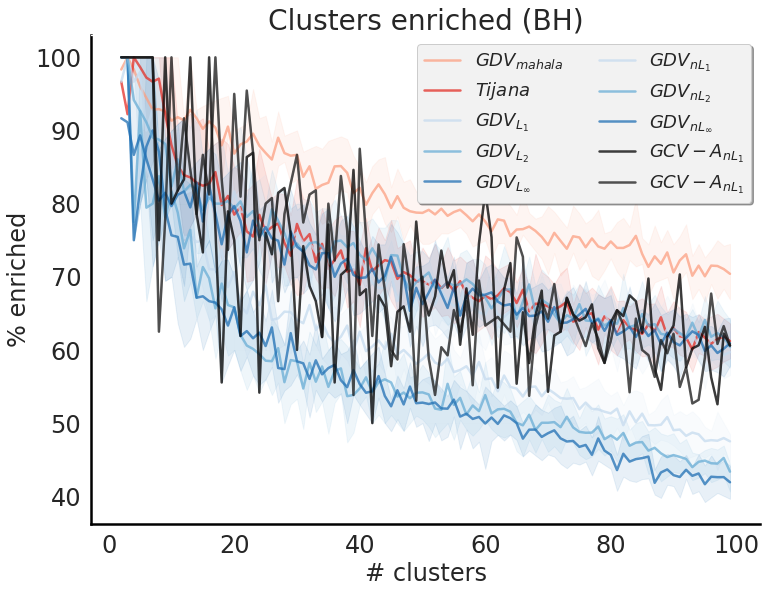

In [118]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    feature  = method.split('_')[0]
    distance = '_'.join(method.split('_')[1:])
    
    ax.plot(cluster_coverages[feature][distance].index, 100*cluster_coverages[feature][distance].T.mean(), 
            label     = f'${name2string[method]}$', 
            color    = colors[method], 
            linewidth = 2.5,
            alpha     = 0.75);
    
    ax.fill_between(cluster_coverages[feature][distance].index, 
                     100*cluster_coverages[feature][distance].T.quantile(0.25), 
                     100*cluster_coverages[feature][distance].T.quantile(0.75), 
                     color    = colors[method],
                     alpha=0.1,);
    ax.set_title(f'Clusters enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=2);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_cluster.png")

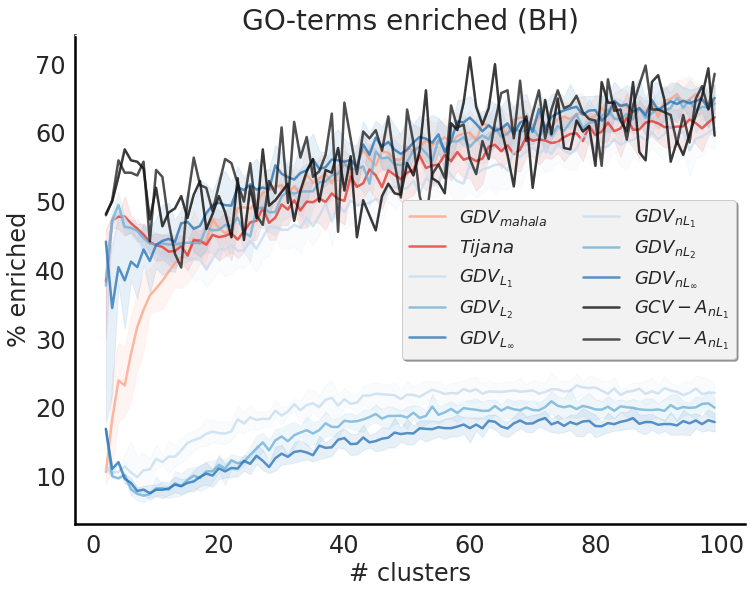

In [120]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    feature  = method.split('_')[0]
    distance = '_'.join(method.split('_')[1:])
    
    ax.plot(GO_coverages[feature][distance].index, 100*GO_coverages[feature][distance].T.mean(), 
            label = f'${name2string[method]}$', 
            color = colors[method], 
            alpha = 0.75,
            linewidth=2.5);
    
    ax.fill_between(GO_coverages[feature][distance].index, 
                     100*GO_coverages[feature][distance].T.quantile(0.25), 
                     100*GO_coverages[feature][distance].T.quantile(0.75), 
                     color = colors[method], 
                     alpha = 0.1,);
    ax.set_title(f'GO-terms enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=2);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_GO-term.png")

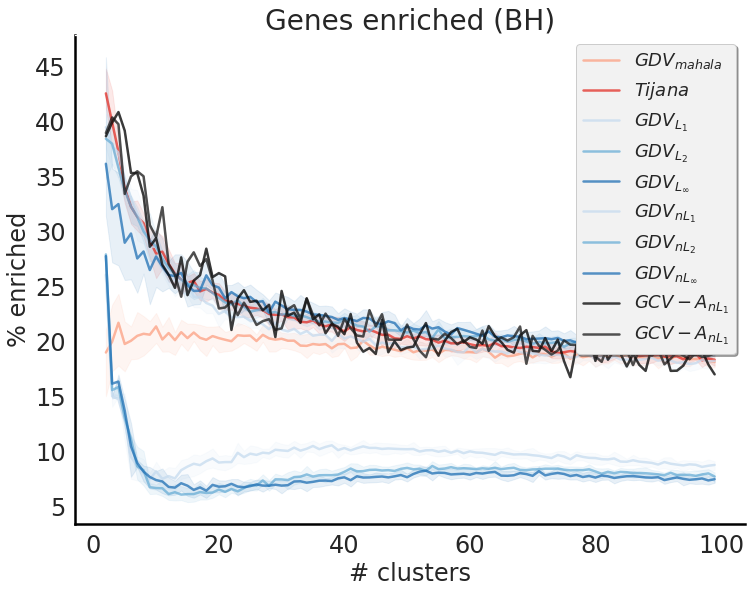

In [121]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    
    feature  = method.split('_')[0]
    distance = '_'.join(method.split('_')[1:])
    
    ax.plot(gene_coverages[feature][distance].index, 100*gene_coverages[feature][distance].T.mean(), 
            label=f'${name2string[method]}$', 
            color = colors[method], 
            alpha = 0.75,
            linewidth = 2.5);
    
    ax.fill_between(gene_coverages[feature][distance].index,
                     100*gene_coverages[feature][distance].T.quantile(0.25), 
                     100*gene_coverages[feature][distance].T.quantile(0.75), 
                     color = colors[method], 
                     alpha = 0.1,);
    ax.set_title(f'Genes enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_gene.png")